# COVID-19 Forecasting with an LSTM

## Data Collection

In [1]:
# All Imports Required Go Here

# The bare basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Advanced plotting libraries (make awesome looking plots)
import plotly
import plotly.express as px
import plotly.graph_objects as go

# Data from the John Hopkins University Dataset on GitHub
# https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series

# Defining the variables required
filenames = ['time_series_covid19_confirmed_global.csv',
             'time_series_covid19_deaths_global.csv',
             'time_series_covid19_recovered_global.csv']

url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'

# Making the main dataframes required for the analysis
confirmed_global = pd.read_csv(url + filenames[0])
deaths_global = pd.read_csv(url + filenames[1])
recovered_global = pd.read_csv(url + filenames[2])
country_cases = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_country.csv')

# Simple Data Cleaning - Removing and renaming the Columns

# Removing the Province/State column, as it is pretty much not of any use
confirmed_global.drop(columns = ['Province/State', 'Lat', 'Long'], inplace = True)
deaths_global.drop(columns = ['Province/State', 'Lat', 'Long'], inplace = True)
recovered_global.drop(columns = ['Province/State', 'Lat', 'Long'], inplace = True)

# Renaming the columns for easier access
confirmed_global.rename(columns = {"Country/Region": "country"}, inplace = True)
deaths_global.rename(columns = {"Country/Region": "country"}, inplace = True)
recovered_global.rename(columns = {"Country/Region": "country"}, inplace = True)

country_cases.rename(columns = {
    "Country_Region" : "country",
    "Last_Update": "last",
    "Confirmed": "confirmed",
    "Deaths": "deaths",
    "Recovered" : "recovered",
    "Active" : "active",
    "Mortality_Rate": "mortality"
}, inplace = True)

# Removing some duplicate values from the table
confirmed_global = confirmed_global.groupby(['country'], as_index = False).sum()
deaths_global = deaths_global.groupby(['country'], as_index = False).sum()
recovered_global = recovered_global.groupby(['country'], as_index = False).sum()

# This value is being changed as there was an error in the original dataset that had to be modified
confirmed_global.at[178, '5/20/20'] = 251667

# Making a dataframe with the country data in sorted order
country_cases_sorted = country_cases.sort_values('confirmed', ascending = False)
country_cases_sorted.index = [x for x in range(len(country_cases_sorted))]

## Data Preprocessing required for the LSTM

The LSTM model will only try to predict and forecast the confirmed COVID-19 cases in India

In [2]:
# This function returns the time series of the country specified

def get_new_cases(country):
    time_series = confirmed_global.melt(id_vars = ['country'], var_name = 'date', value_name = 'cases')
    time_series = time_series[time_series['country'] == country]
    time_series = time_series.drop(['country'], axis = 1)
    time_series_cases = time_series['cases'].diff()
    time_series_cases = time_series_cases.replace(np.nan, 0)
    time_series = pd.DataFrame(data = {
        'date': time_series.date,
        'cases': time_series_cases
    })
    time_series.index = [x for x in range(len(time_series))]
    return time_series

In [3]:
# The main dataset that will be used for the model
dataset = get_new_cases('India')

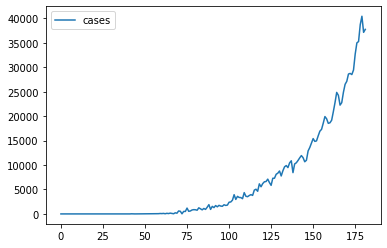

In [5]:
# Visualizing the dataset
dataset.plot()